In [ ]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.
import kagglehub
furkannakdagg_amazon_reviews_path = kagglehub.dataset_download('furkannakdagg/amazon-reviews')

print('Data source import complete.')


In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/amazon-reviews/amazon.xlsx


In [ ]:
!pip install nltk

In [ ]:
!pip install textblob

In [ ]:
!pip install wordcloud

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.graph_objs as go
import plotly.io as pio

import nltk
from nltk.corpus import stopwords
from nltk.sentiment import SentimentIntensityAnalyzer
from textblob import Word, TextBlob
from wordcloud import WordCloud
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

from sklearn.model_selection import cross_val_score, GridSearchCV, cross_validate
from sklearn.preprocessing import LabelEncoder

from sklearn.ensemble import RandomForestClassifier

In [ ]:
data=pd.read_excel('/kaggle/input/amazon-reviews/amazon.xlsx')
data

,Star,HelpFul,Title,Review
0,5,0,looks great,Happy with it
1,5,0,Pattern did not align between the two panels.,Good quality material however the panels are m...
2,5,0,Imagery is stretched. Still fun.,Product was fun for bedroom windows.<br />Imag...
3,5,0,Que se ven elegantes muy finas,Lo unico que me gustaria es que sean un poco ...
4,5,0,Wow great purchase,Great bang for the buck I can't believe the qu...
...,...,...,...,...
5606,4,0,Recommend,Great product for reasonable money. Delivered...
5607,5,0,"Terrible , different colors. I returned",Color is way off and panels do not match
5608,5,0,Extremely pleasing,These are great for my studio as they compleme...
5609,5,0,Perfect,Brought out the beauty in kids room. They love...


In [ ]:
data.isnull().sum()

Star        0
HelpFul     0
Title      52
Review     18
dtype: int64

In [ ]:
data.dropna(subset=['Review'], inplace=True)

In [ ]:
data.isnull().sum()

Star        0
HelpFul     0
Title      43
Review      0
dtype: int64

In [ ]:
data['Review']=data['Review'].str.lower()

In [ ]:
data['Review']=data['Review'].str.replace('[^\w\s]', '')

In [ ]:
data['Review']=data['Review'].str.replace('\d', '')

In [ ]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [ ]:
sw=stopwords.words('english')

In [ ]:
data['Review']=data['Review'].apply(lambda x: " ".join(x for x in str(x).split() if x not in sw))

In [ ]:
temp_df=pd.Series(' '.join(data['Review']).split()).value_counts()

In [ ]:
temp_df

love          1271
curtains      1251
like          1017
look           818
great          721
              ... 
science          1
artistic         1
geeky            1
grandchild       1
installed!       1
Name: count, Length: 10592, dtype: int64

In [ ]:
drops=temp_df[temp_df<=1]

In [ ]:
data['Review']=data['Review'].apply(lambda x: " ".join(x for x in x.split() if x not in drops))

In [ ]:
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /usr/share/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

In [ ]:
data['Review']=data['Review'].apply(lambda x: " ".join([Word(word).lemmatize() for word in x.split()]))

In [ ]:
tf = data['Review'].apply(lambda x: pd.Series(x.split(" ")).value_counts()).sum(axis=0).reset_index()

In [ ]:
tf.columns=["words","tf"]

In [ ]:
tf.head()

,words,tf
0,happy,171.0
1,good,453.0
2,quality,609.0
3,material,398.0
4,however,36.0


<Axes: xlabel='words'>

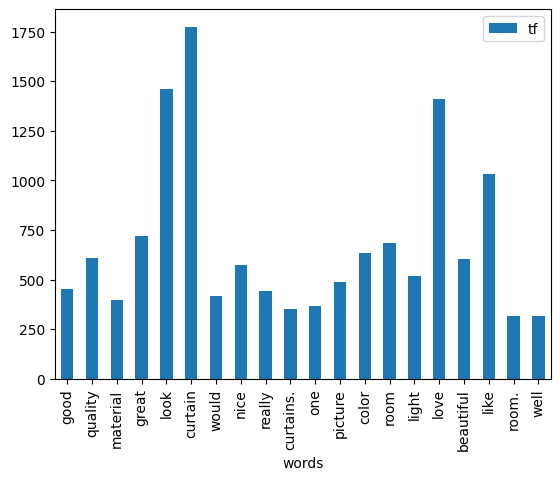

In [ ]:
tf[tf['tf']>300].plot.bar(x='words', y='tf')

In [ ]:
text=" ".join(i for i in data['Review'])

(-0.5, 399.5, 199.5, -0.5)

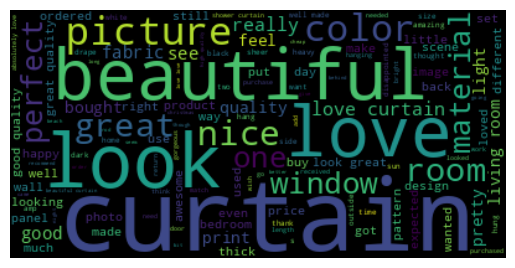

In [ ]:
wordcloud=WordCloud().generate(text)
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")

In [ ]:
data["Review"].head()

0                                                happy
1                  good quality material however panel
2    product fun bedroom windows.<br bit stretched,...
3                              lo que e que un poco ma
4    great bang can't believe quality material. vib...
Name: Review, dtype: object

In [ ]:
nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /usr/share/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

In [ ]:
sia=SentimentIntensityAnalyzer()
data['Review'][0:10].apply(lambda x: sia.polarity_scores(x))

0    {'neg': 0.0, 'neu': 0.0, 'pos': 1.0, 'compound...
1    {'neg': 0.0, 'neu': 0.58, 'pos': 0.42, 'compou...
2    {'neg': 0.0, 'neu': 0.571, 'pos': 0.429, 'comp...
3    {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...
4    {'neg': 0.0, 'neu': 0.495, 'pos': 0.505, 'comp...
5    {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...
6    {'neg': 0.0, 'neu': 0.631, 'pos': 0.369, 'comp...
7    {'neg': 0.0, 'neu': 0.541, 'pos': 0.459, 'comp...
8    {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...
9    {'neg': 0.0, 'neu': 0.753, 'pos': 0.247, 'comp...
Name: Review, dtype: object

In [ ]:
data['Review'][0:10].apply(lambda x: sia.polarity_scores(x)['compound'])

0    0.5719
1    0.4404
2    0.7184
3    0.0000
4    0.9042
5    0.0000
6    0.6249
7    0.9268
8    0.0000
9    0.7096
Name: Review, dtype: float64

In [ ]:
data["polarity_score"]=data['Review'].apply(lambda x: sia.polarity_scores(x)['compound'])

In [ ]:
data['Review'][0:10].apply(lambda x: "pos" if sia.polarity_scores(x)['compound']>0 else "neg")

0    pos
1    pos
2    pos
3    neg
4    pos
5    neg
6    pos
7    pos
8    neg
9    pos
Name: Review, dtype: object

In [ ]:
rev_pol= pd.concat([data['Review'][0:10], data["Review"][0:10].apply(lambda x: "pos" if sia.polarity_scores(x)['compound']>0 else "neg")],axis=1)
rev_pol.columns=['Review','Polarity Scores']

In [ ]:
rev_pol

,Review,Polarity Scores
0,happy,pos
1,good quality material however panel,pos
2,"product fun bedroom windows.<br bit stretched,...",pos
3,lo que e que un poco ma,neg
4,great bang can't believe quality material. vib...,pos
5,look different photo,neg
6,exactly looking for. heavy material. great pri...,pos
7,"looking picture, thought curtain would thinner...",pos
8,much thought would wasn’t really expecting wan...,neg
9,curtain picture shows. 3rd set ambesonne curta...,pos


In [ ]:
data['sentiment']=data['Review'].apply(lambda x: "pos" if sia.polarity_scores(x)['compound']>0 else "neg")
data['sentiment'].value_counts()

sentiment
pos    4786
neg     807
Name: count, dtype: int64

In [ ]:
data.groupby("sentiment")['Star'].mean()

sentiment
neg    3.503098
pos    4.560176
Name: Star, dtype: float64

In [ ]:
data['sentiment']=LabelEncoder().fit_transform(data['sentiment'])

In [ ]:
Y=data['sentiment']
X=data['Review']

In [ ]:
corpus = ['This is the first document.',
          'This document is the second document.',
          'And this is the third one.',
          'Is this the first document?']
vectorizer=CountVectorizer(analyzer='word', ngram_range=(2,2))
X_c=vectorizer.fit_transform(corpus)
vectorizer.get_feature_names_out()

array(['and this', 'document is', 'first document', 'is the', 'is this',
       'second document', 'the first', 'the second', 'the third',
       'third one', 'this document', 'this is', 'this the'], dtype=object)

In [ ]:
X_c.toarray()

array([[0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0],
       [0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0],
       [1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0],
       [0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1]])

In [ ]:
vectorizer=CountVectorizer()
X_count=vectorizer.fit_transform(X)

In [ ]:
tf_idf=TfidfVectorizer()
X_tfidf=tf_idf.fit_transform(X)


In [ ]:
rf_model=RandomForestClassifier().fit(X_count,Y)
cross_val_score(rf_model, X_count, Y, cv=5, n_jobs=-1).mean()

0.9331315815136503

In [ ]:
rf_model=RandomForestClassifier().fit(X_tfidf,Y)
cross_val_score(rf_model, X_tfidf, Y, cv=5, n_jobs=-1).mean()

0.9247269076497829

In [ ]:
def score(method_list):
    scores=[]
    for method in method_list:
        rf_model=RandomForestClassifier().fit(method,Y)
        scores.append(cross_val_score(rf_model, method, Y, cv=5, n_jobs=-1).mean())

    scores_df=pd.DataFrame({'Methods': ['Countvectors', 'TF-IDF'], 'Scores': scores})
    trace1 = go.Bar(
                    y = scores_df["Methods"],
                    x = scores_df["Scores"],
                    name = "Accuracy Plot",
                    text=[round(i,5) for i in scores_df['Scores']],
                    marker = dict(color = ['#2ECC71','#34495E'],
                                 line=dict(color='rgb(0,0,0)',width=1.5)),
        orientation='h', textposition = 'inside'
    )
    data = [trace1]
    layout = go.Layout(barmode = "group",
                       title={'text': "Scores" ,
                                 'y':0.9,
                                 'x':0.5,
                                 'xanchor': 'center',
                                 'yanchor': 'top'},
                          template='plotly_white')
    fig = go.Figure(data = data, layout = layout)
    pio.show(fig)

method_list = [X_count, X_tfidf]
score(method_list)

In [ ]:
new_review=pd.Series('This is terrible product')
new_review = TfidfVectorizer().fit(X).transform(new_review)
rf_model.predict(new_review)

array([0])